In [8]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

# All images and tags

In [ ]:
df = pd.read_csv('../../../docker_emse/csv/prepared_data/compact.csv.gz')

In [ ]:
df.query('kind=="official"')[['image','hash']].image.size

In [6]:
df.query('kind=="official"')[['image','hash']].set_index('image').drop_duplicates().shape

(12427, 1)

In [7]:
df.query('kind=="community"')[['image','hash']].image.size

5718715

In [8]:
df.query('kind=="community"')[['image','hash']].set_index('image').drop_duplicates().shape

(4381972, 1)

# Load images

In [2]:
images = pd.read_csv('../../../docker_emse/csv/for_analysis/installed_packages.csv',
                    usecols = ['image','last_updated','type','release'])
images.drop_duplicates(inplace=True)
images.shape

(140498, 4)

In [3]:
images['slug'] = images['image'].apply(lambda x: '/'.join(x.split(':')[0:2]))

In [4]:
images.replace({'type': type_map}, inplace=True)
images.replace({'release': release_map}, inplace=True)

In [4]:
images.slug.unique().size

14007

In [34]:
print(images.query('type == "o"').image.unique().size, images.query('type == "c"').image.unique().size)

(9330, 131168)

# Load popularity

In [ ]:
pop = pd.concat([pd.read_csv('../../../docker_emse/csv/'+file+'.zip', usecols=['slug','popularity']) 
                        for file in ['official_images','community_images']])
pop.shape

In [ ]:
pop.popularity.describe().apply(lambda x: format(x, 'f'))

In [ ]:
mask = pop.slug.isin(images.slug)
pop = pop[mask]

In [ ]:
images = (images
          .merge(pop,
                on = 'slug',
                how = 'left')
         )
images.shape

In [ ]:
images.popularity.describe().apply(lambda x: format(x, 'f'))

### Let's check when images were last updated

In [5]:
images = images.query('last_updated != "None"')
images['last_updated'] = pd.to_datetime(images['last_updated'])

In [22]:
df_tmp=(images.
        groupby(['release','last_updated','type']).
        count().
        reset_index()
       )

df_tmp = (df_tmp
          .drop('slug', axis=1)
          .pivot_table(index=['last_updated','type'], columns='release', values='image')
          .fillna(0)
          .reset_index())

In [38]:
df_

release,Oldstable,Stable,Testing
last_updated,,,
2016-06-30,1.0,0.0,0.0
2016-09-30,607.0,0.0,0.0
2016-12-31,914.0,1.0,0.0
2017-03-31,1395.0,17.0,0.0
2017-06-30,2302.0,25.0,0.0
2017-09-30,5502.0,1663.0,15.0
2017-12-31,6195.0,2335.0,30.0
2018-03-31,7082.0,3354.0,64.0
2018-06-30,7944.0,5849.0,79.0


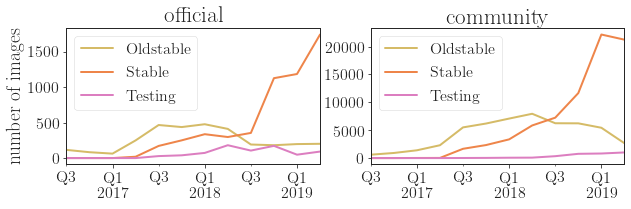

In [95]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(10,2.5)
for j, genre in enumerate(['official','community']):
    df_=(df_tmp.
         query('type =="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))[['Oldstable','Stable','Testing']].
         agg(sum)
        )    
    ax=df_.plot(ax=axes[j], linewidth=2, colors=[colors[x] for x in ['Oldstable','Stable','Testing']])
    if j==0:
        ax.set_ylabel('number of images')
        plt.yticks(pd.np.arange(0, 2000, 100))
    else:
        plt.yticks(pd.np.arange(0, 25000, 5000))
    ax.set(
        xlabel='',
        title=genre,
        xlim=date_period,)
    minorLocator   = MultipleLocator(2)
    ax.xaxis.set_minor_locator(minorLocator)
    
    ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/number_images.pdf', bbox_inches='tight', facecolor='white')

In [104]:
for i, t in enumerate(['official','community']):
    df_tmp=(images.query('type =="'+t+'" ')
            .groupby(['year'])
            .count()
           )
    print(df_tmp.image*100/len(images.query('type =="'+t+'" ')))

year
2016     2.132905
2017    18.531618
2018    42.047160
2019    37.288317
Name: image, dtype: float64
year
2016     1.161124
2017    14.850647
2018    43.339737
2019    40.648491
Name: image, dtype: float64


# Load packages

In [2]:
packages = pd.read_csv('../../../docker_emse/csv/for_analysis/installed_packages.csv',
                      usecols=['image','package','type','version','release'])
packages.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(46272487, 5)

In [3]:
packages.release.unique()

array(['stretch', 'buster', 'jessie'], dtype=object)

In [5]:
'number of images', packages.image.unique().size

('number of images', 140498)

In [6]:
packages[['image','type']].drop_duplicates().groupby('type').count()

,image
type,
c,131168
o,9330


In [8]:
packages[['image','type','release']].drop_duplicates().groupby(['type','release']).count()

image
type release       
c    buster    3114
     jessie   52520
     stretch  75534
o    buster     741
     jessie    3085
     stretch   5504

In [9]:
packages[['image','release']].drop_duplicates().groupby('release').count()

,image
release,
buster,3855
jessie,55605
stretch,81038


In [6]:
packages.query('type == "o"').shape, packages.query('type == "c"').shape

((2042387, 5), (44230100, 5))

In [15]:
packages.query('type == "o"').groupby('image').count()[['package']].package.median()

185.0

In [14]:
packages.query('type == "c"').groupby('image').count()[['package']].package.median()

377.0

# Vulnerabilities

In [96]:
vuls = pd.read_csv('../../../docker_emse/csv/for_analysis/vulnerabilities.csv')
vuls = vuls.drop('archive', axis=1).drop_duplicates()
vuls.shape

(63601, 7)

In [97]:
urgency_map={'low**':'Low',
            'low*':'Low',
            'low':'Low',
            'medium**':'Medium',
            'medium**':'Medium',
            'medium':'Medium',
            'high**':'High',
            'high*':'High',
            'high':'High',
            'unimportant': pd.np.nan,
            'not yet assigned': pd.np.nan,
            'end-of-life': pd.np.nan,
           }

vuls = vuls.query('status != "undetermined"').copy()
vuls = (vuls
        .replace({'urgency': urgency_map})
        .dropna(subset=['urgency'])
        .drop_duplicates()
       )

In [98]:
vuls.shape

(46379, 7)

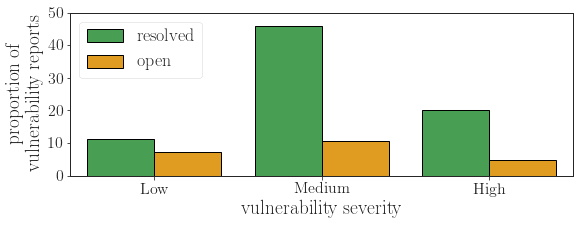

In [118]:
df_tmp=vuls.groupby(['urgency','status']).count().reset_index()
df_tmp['source']=df_tmp['source']*100.0/len(vuls)
df_tmp=df_tmp.sort_values('urgency', ascending=False)

ax = sns.barplot(x="urgency", 
                 y="source", 
                 hue="status", 
                 order=['Low','Medium','High'],
                 hue_order=['resolved', 'open'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(9,3)
ax.set_xlabel("vulnerability severity ")
ax.set_ylabel('proportion of \nvulnerability reports')
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.yticks(np.arange(0, 60, 10))

ax.legend(loc='upper left', fontsize=18)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/all_vuls.pdf', bbox_inches='tight', facecolor='white')

In [18]:
vuls.source.unique().size

557

In [17]:
vuls.groupby(['status']).count().source*100.0/len(vuls)

status
open        22.900451
resolved    77.099549
Name: source, dtype: float64

In [19]:
vuls.groupby(['status']).count().source

status
open        10621
resolved    35758
Name: source, dtype: int64

In [20]:
vuls.groupby(['urgency']).count().source*100.0/len(vuls)

urgency
High      24.970353
Low       18.523470
Medium    56.506177
Name: source, dtype: float64

# Bugs

In [119]:
bugs = pd.read_csv('../../../docker_emse/csv/for_analysis/bugs.csv')
bugs.drop_duplicates(inplace=True)
bugs.shape

(371639, 10)

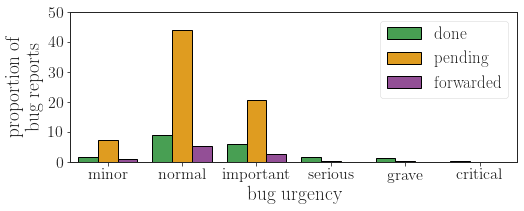

In [127]:
df_tmp=bugs.groupby(['severity','status']).count().reset_index()
df_tmp['source']=df_tmp['source']*100.0/len(bugs)
df_tmp=df_tmp.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="source", 
                 hue="status", 
                 hue_order = ['done','pending','forwarded'],
                 order=['minor', 'normal', 'important', 'serious','grave','critical'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(8,2.75)
ax.set_xlabel("bug urgency")
ax.set_ylabel('proportion of \nbug reports')
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.yticks(np.arange(0, 60, 10))

ax.legend(loc='upper right', fontsize=17)
ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/all_bugs.pdf', bbox_inches='tight', facecolor='white')

In [32]:
bugs.source.unique().size

3400

In [22]:
bugs.groupby(['status']).count().source*100.0/len(bugs)

status
done         19.530512
forwarded     8.567454
pending      71.902034
Name: source, dtype: float64

In [23]:
bugs.groupby(['status']).count().source

status
done          72583
forwarded     31840
pending      267216
Name: source, dtype: int64

In [33]:
bugs.groupby(['severity']).count().source*100.0/len(bugs)

severity
critical      0.208805
grave         1.375797
important    29.434209
minor         9.502770
normal       57.840001
serious       1.638418
Name: source, dtype: float64

In [14]:
severity_map={'minor':'Lower',
            'normal':'Lower',
            'important':'Higher',
            'grave':'Higher',
            'serious':'Higher',
            'critical':'Higher',
           }

bugs = (bugs
        .replace({'severity': severity_map})
        .drop_duplicates()
       )

Text(0.18, 1.15, 'Status:')

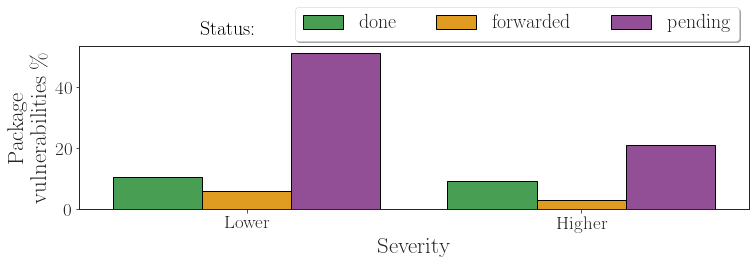

In [15]:
df_tmp=bugs.groupby(['severity','status']).count().reset_index()
df_tmp['source']=df_tmp['source']*100.0/len(bugs)
df_tmp=df_tmp.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="source", 
                 hue="status", 
                 hue_order = ['done','forwarded','pending'],
                 #order=['Lower', 'Medium', 'Higher'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Package \n vulnerabilities \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
#ax.figure.savefig('../../../seneca_research/docker_debian/figures/all_vuls.pdf', bbox_inches='tight', facecolor='white')